In [1]:
# https://www.kaggle.com/vbookshelf/simple-cell-segmentation-with-keras-and-u-net

In [5]:
import pandas as pd
import numpy as np
import os
import sys
import random

import matplotlib.pyplot as plt
%matplotlib inline


from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Set some parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
NUM_TEST_IMAGES = 30

In [7]:
# get a list of files in each folder
img_list = os.listdir('Roads DataSet/road_segmentation_ideal/training/input')
mask_list = os.listdir('Roads DataSet/road_segmentation_ideal/training/output')

# create a dataframe
df_images = pd.DataFrame(img_list, columns=['image_id'])

# filter out the non image file that's called .htaccess
df_images = df_images[df_images['image_id'] != '.htaccess']

def check_for_mask(x):
    if x in mask_list:
        return 'yes'
    else:
        return 'no'
    
# create a new column called 'has_mask'
df_images['has_mask'] = df_images['image_id'].apply(check_for_mask)

df_images.head()


image_id has_mask
0   img-1000Cropped.png      yes
1  img-1000Cropped2.png      yes
2   img-1001Cropped.png       no
3  img-1001Cropped2.png       no
4   img-1002Cropped.png      yes

In [8]:
df_masks = df_images[df_images['has_mask'] == 'yes']

# create a new column called mask_id that is just a copy of image_id
df_masks['mask_id'] = df_masks['image_id']

df_masks.shape

(1531, 3)

In [9]:
df_masks.head(10)

image_id has_mask               mask_id
0    img-1000Cropped.png      yes   img-1000Cropped.png
1   img-1000Cropped2.png      yes  img-1000Cropped2.png
4    img-1002Cropped.png      yes   img-1002Cropped.png
5   img-1002Cropped2.png      yes  img-1002Cropped2.png
6   img-1003Cropped2.png      yes  img-1003Cropped2.png
7    img-1004Cropped.png      yes   img-1004Cropped.png
8   img-1004Cropped2.png      yes  img-1004Cropped2.png
9    img-1005Cropped.png      yes   img-1005Cropped.png
10  img-1005Cropped2.png      yes  img-1005Cropped2.png
11   img-1006Cropped.png      yes   img-1006Cropped.png

In [10]:
# create a test set
df_test = df_masks.sample(NUM_TEST_IMAGES, random_state=101)

# Reset the index.
# This is so that we can use loc to access mask id's later.
df_test = df_test.reset_index(drop=True)

# create a list of test images
test_images_list = list(df_test['image_id'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_masks = df_masks[~df_masks['image_id'].isin(test_images_list)]

print(df_masks.shape)
print(df_test.shape)

(1501, 3)
(30, 3)


In [11]:
# Get lists of images and their masks.
image_id_list = list(df_masks['image_id'])
mask_id_list = list(df_masks['mask_id'])
test_id_list = list(df_test['image_id'])

In [12]:
# Get and resize train images and masks
X_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
X_test = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)



In [13]:
# X_train

print('Getting and resizing train images... ')
sys.stdout.flush()
for n, image_id in tqdm(enumerate(image_id_list), total=len(image_id_list)):
    
    img = imread('Roads DataSet/road_segmentation_ideal/training/input/'+ image_id)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
   
    
X_train.shape

Getting and resizing train images... 


100%|█████████████████████████████████████████████████████████████████████████████| 1501/1501 [00:06<00:00, 216.41it/s]


(1501, 128, 128, 3)

In [14]:
# X_test

X_test = np.zeros((len(test_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, image_id in tqdm(enumerate(test_id_list), total=len(test_id_list)):
    
    img = imread('Roads DataSet/road_segmentation_ideal/training/input/'+ image_id)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    
X_test.shape

Getting and resizing test images ... 


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 203.97it/s]


(30, 128, 128, 3)

In [15]:
# Y_train

for i, mask_id in enumerate(mask_id_list):
    
    path_mask = 'Roads DataSet/road_segmentation_ideal/training/output/' + mask_id
    
    # read the image using skimage
    mask = imread(path_mask)
    
    # resize the image
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    mask = np.expand_dims(mask, axis=-1)
    
    # insert the image into Y_Train
    Y_train[i] = mask

Y_train.shape

(1501, 128, 128, 1)

In [16]:
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers.core import Dropout, Lambda
from tensorflow.python.keras.layers.convolutional import Conv2D, Conv2DTranspose
from tensorflow.python.keras.layers.pooling import MaxPooling2D
from tensorflow.python.keras.layers.merge import concatenate
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras import backend as K

import tensorflow as tf

In [57]:
class SamplePredictionsCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, image_index = 10, prediction_thresh = 0.5,*args,**kwargs):
    
        self.image_index = image_index
        self.prediction_thresh = prediction_thresh

        super().__init__(*args,**kwargs)
        

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []
            
    def on_epoch_end(self, epoch, logs={}):
        
        print("sampling a predictive mask")

        # plotting image
        plt.subplot(3,3,1)
        test_image = X_test[self.image_index]
        plt.imshow(test_image)
        plt.title('Test Image', fontsize=14)
        plt.axis('off')

        # plotting true mask
        plt.subplot(3,3,2)
        mask_id = df_test.loc[self.image_index,'mask_id']
        path_mask = 'Roads DataSet/road_segmentation_ideal/training/output/' + mask_id
        mask = imread(path_mask)
        mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        plt.imshow(mask, cmap='gray')
        plt.title('True Mask', fontsize=14)
        plt.axis('off')

        # plotting predicted mask
        plt.subplot(3,3,3)
        test_mask = self.model.predict(np.expand_dims(X_test[self.image_index], axis=0)) > self.prediction_thresh
        plt.imshow(test_mask[0], cmap='gray')
        plt.title('Pred Mask', fontsize=14)
        plt.axis('off')
        
        plt.savefig('gif/' + str(epoch) + '.png')

        plt.tight_layout()
        plt.show()
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
       
        #clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.savefig('gif_graph/' + str(epoch) + '.png')
        plt.show();


In [58]:
# source: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

s = Lambda(lambda x: x / 255)(inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s) 
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()



#try this later
# https://github.com/reachsumit/deep-unet-for-satellite-image-segmentation/blob/master/unet_model.py

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 128, 128, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_228 (Conv2D)             (None, 128, 128, 16) 448         lambda_12[0][0]                  
__________________________________________________________________________________________________
dropout_108 (Dropout)           (None, 128, 128, 16) 0           conv2d_228[0][0]                 
___________________________________________________________________________________________

Train on 1350 samples, validate on 151 samples
Epoch 1/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.5910
Epoch 00001: val_loss improved from inf to 0.31312, saving model to model.h5
sampling a predictive mask


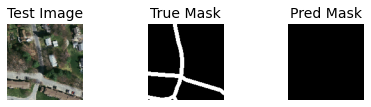

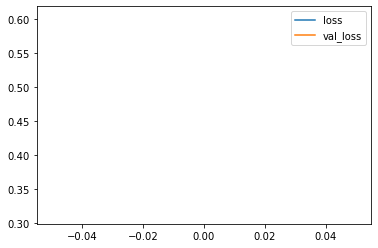

1350/1350 [==============================] - 5s 4ms/sample - loss: 0.6040 - val_loss: 0.3131
Epoch 2/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.3358
Epoch 00002: val_loss did not improve from 0.31312
sampling a predictive mask


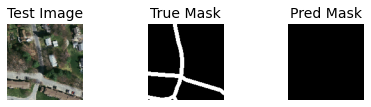

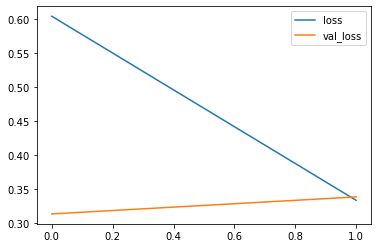

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.3331 - val_loss: 0.3381
Epoch 3/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.3079
Epoch 00003: val_loss improved from 0.31312 to 0.29804, saving model to model.h5
sampling a predictive mask


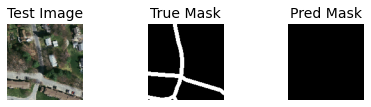

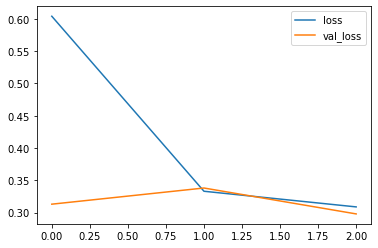

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.3089 - val_loss: 0.2980
Epoch 4/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.3081
Epoch 00004: val_loss did not improve from 0.29804
sampling a predictive mask


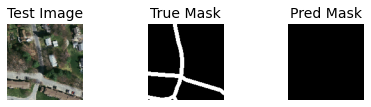

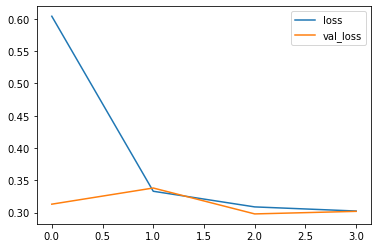

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.3025 - val_loss: 0.3020
Epoch 5/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.2890
Epoch 00005: val_loss improved from 0.29804 to 0.29290, saving model to model.h5
sampling a predictive mask


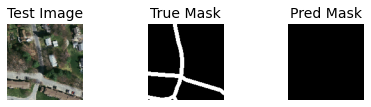

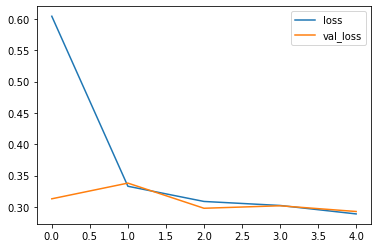

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.2890 - val_loss: 0.2929
Epoch 6/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.2873
Epoch 00006: val_loss improved from 0.29290 to 0.25936, saving model to model.h5
sampling a predictive mask


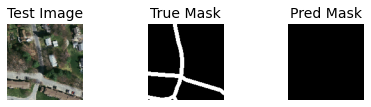

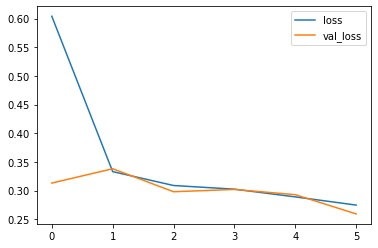

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.2748 - val_loss: 0.2594
Epoch 7/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.2582
Epoch 00007: val_loss improved from 0.25936 to 0.25232, saving model to model.h5
sampling a predictive mask


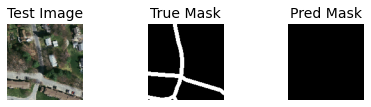

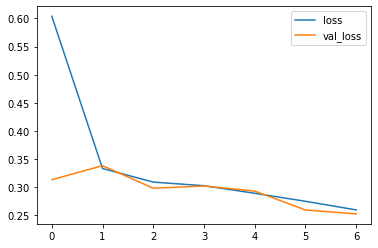

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.2594 - val_loss: 0.2523
Epoch 8/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.2410
Epoch 00008: val_loss improved from 0.25232 to 0.21520, saving model to model.h5
sampling a predictive mask


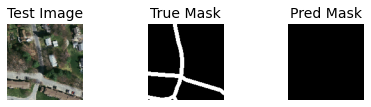

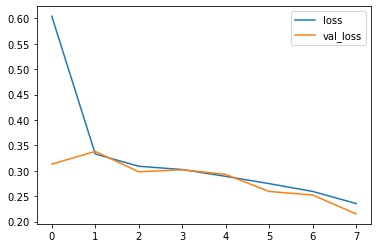

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.2356 - val_loss: 0.2152
Epoch 9/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.2113
Epoch 00009: val_loss did not improve from 0.21520
sampling a predictive mask


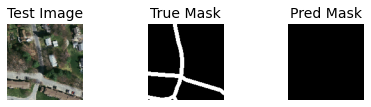

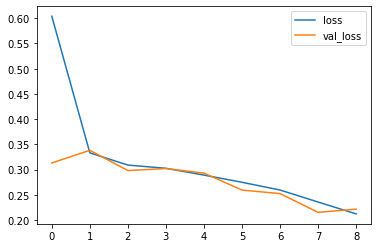

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.2121 - val_loss: 0.2215
Epoch 10/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1995
Epoch 00010: val_loss improved from 0.21520 to 0.19166, saving model to model.h5
sampling a predictive mask


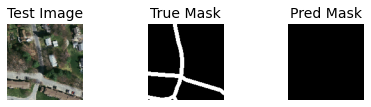

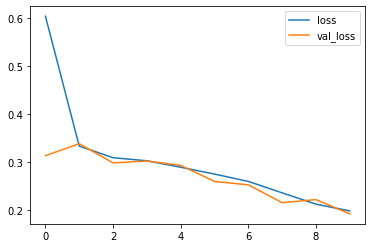

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1979 - val_loss: 0.1917
Epoch 11/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1902
Epoch 00011: val_loss did not improve from 0.19166
sampling a predictive mask


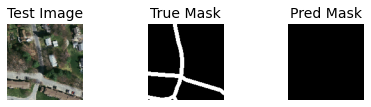

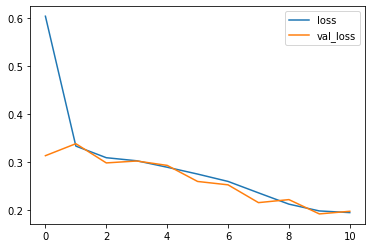

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1944 - val_loss: 0.1971
Epoch 12/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1934
Epoch 00012: val_loss did not improve from 0.19166
sampling a predictive mask


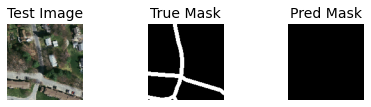

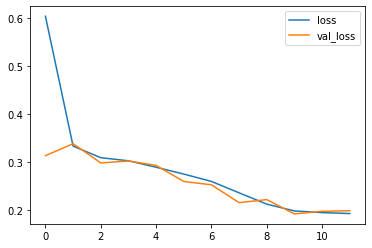

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1924 - val_loss: 0.1982
Epoch 13/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1923
Epoch 00013: val_loss improved from 0.19166 to 0.17927, saving model to model.h5
sampling a predictive mask


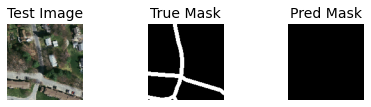

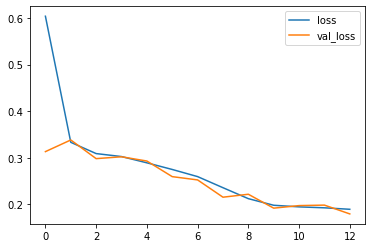

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1892 - val_loss: 0.1793
Epoch 14/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1869
Epoch 00014: val_loss did not improve from 0.17927
sampling a predictive mask


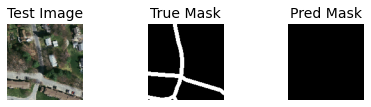

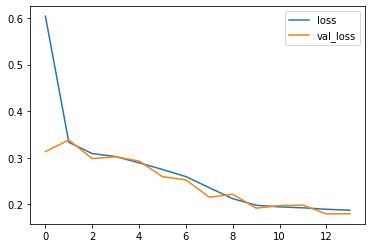

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1872 - val_loss: 0.1797
Epoch 15/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1864
Epoch 00015: val_loss did not improve from 0.17927
sampling a predictive mask


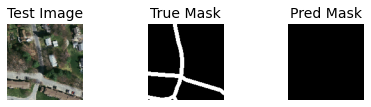

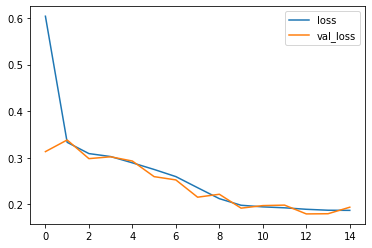

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1869 - val_loss: 0.1937
Epoch 16/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1863
Epoch 00016: val_loss did not improve from 0.17927
sampling a predictive mask


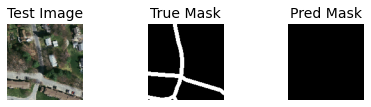

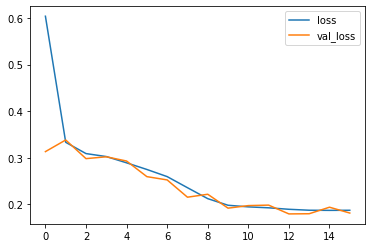

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1871 - val_loss: 0.1812
Epoch 17/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1835
Epoch 00017: val_loss improved from 0.17927 to 0.17162, saving model to model.h5
sampling a predictive mask


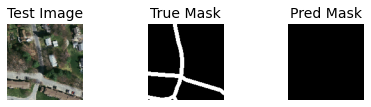

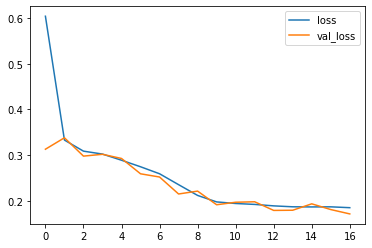

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1852 - val_loss: 0.1716
Epoch 18/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1850
Epoch 00018: val_loss did not improve from 0.17162
sampling a predictive mask


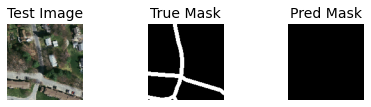

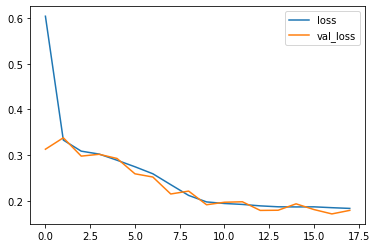

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1837 - val_loss: 0.1794
Epoch 19/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1812
Epoch 00019: val_loss did not improve from 0.17162
sampling a predictive mask


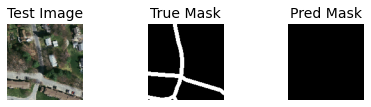

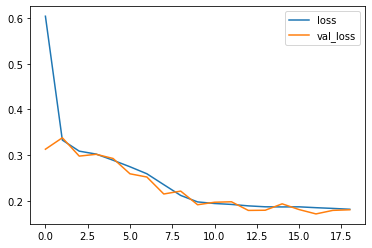

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1818 - val_loss: 0.1807
Epoch 20/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1790
Epoch 00020: val_loss did not improve from 0.17162
sampling a predictive mask


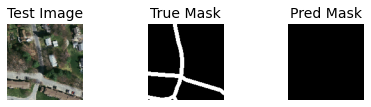

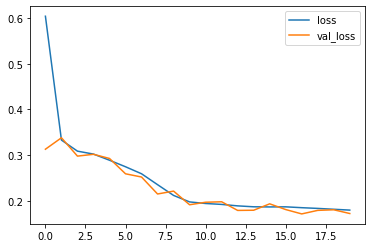

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1800 - val_loss: 0.1725
Epoch 21/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1779
Epoch 00021: val_loss improved from 0.17162 to 0.16825, saving model to model.h5
sampling a predictive mask


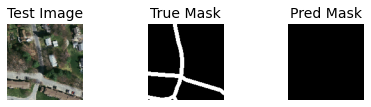

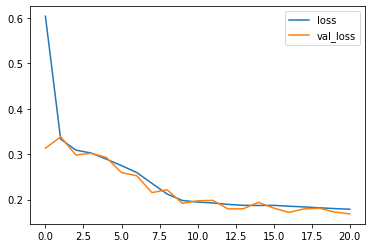

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1786 - val_loss: 0.1683
Epoch 22/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1764
Epoch 00022: val_loss improved from 0.16825 to 0.16608, saving model to model.h5
sampling a predictive mask


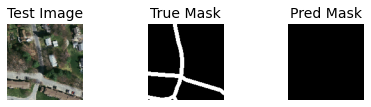

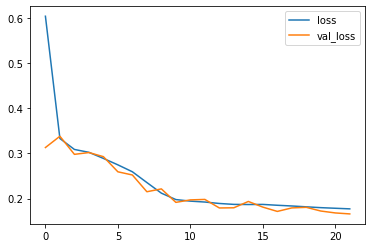

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1773 - val_loss: 0.1661
Epoch 23/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1709
Epoch 00023: val_loss did not improve from 0.16608
sampling a predictive mask


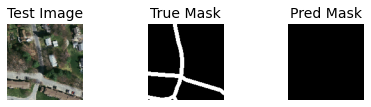

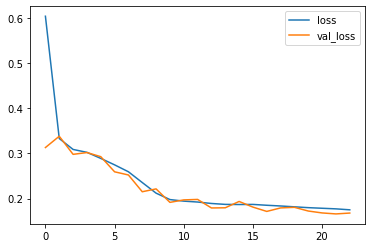

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1752 - val_loss: 0.1680
Epoch 24/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1742
Epoch 00024: val_loss did not improve from 0.16608
sampling a predictive mask


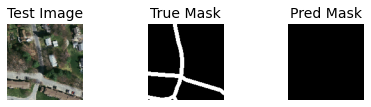

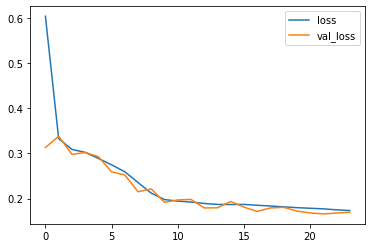

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1736 - val_loss: 0.1697
Epoch 25/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1742
Epoch 00025: val_loss did not improve from 0.16608
sampling a predictive mask


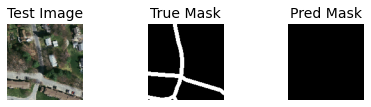

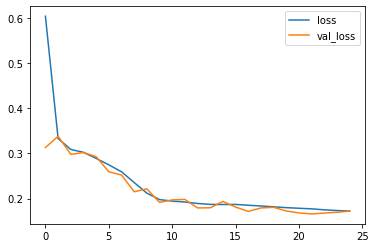

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1724 - val_loss: 0.1723
Epoch 26/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1753
Epoch 00026: val_loss did not improve from 0.16608
sampling a predictive mask


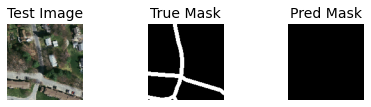

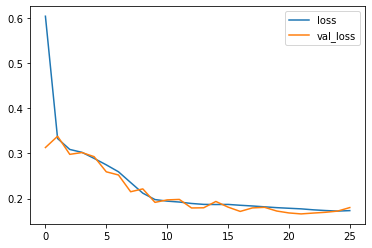

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1734 - val_loss: 0.1801
Epoch 27/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1704
Epoch 00027: val_loss did not improve from 0.16608
sampling a predictive mask


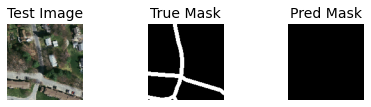

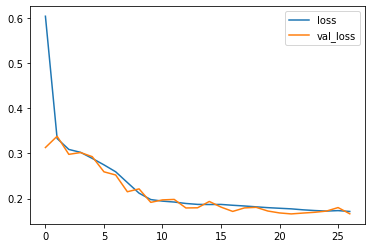

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1715 - val_loss: 0.1664
Epoch 28/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1742
Epoch 00028: val_loss improved from 0.16608 to 0.16418, saving model to model.h5
sampling a predictive mask


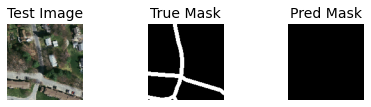

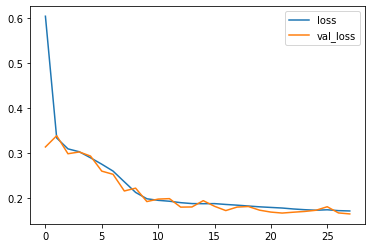

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1708 - val_loss: 0.1642
Epoch 29/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1696
Epoch 00029: val_loss improved from 0.16418 to 0.16400, saving model to model.h5
sampling a predictive mask


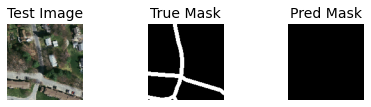

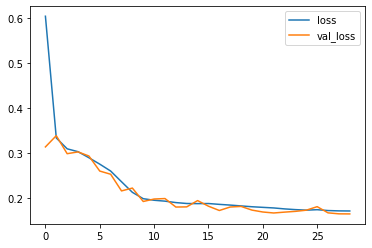

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1705 - val_loss: 0.1640
Epoch 30/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1675
Epoch 00030: val_loss did not improve from 0.16400
sampling a predictive mask


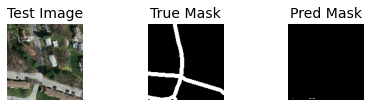

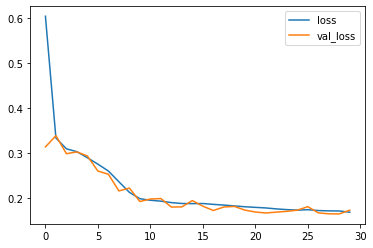

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1678 - val_loss: 0.1723
Epoch 31/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1695
Epoch 00031: val_loss did not improve from 0.16400
sampling a predictive mask


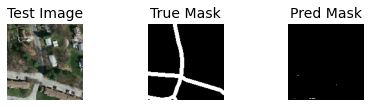

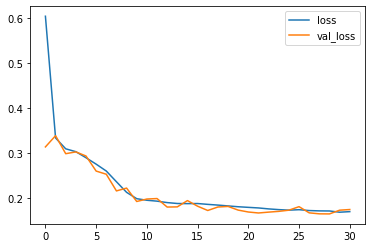

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1691 - val_loss: 0.1738
Epoch 32/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1667
Epoch 00032: val_loss did not improve from 0.16400
sampling a predictive mask


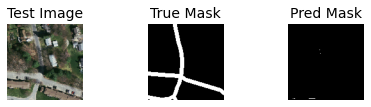

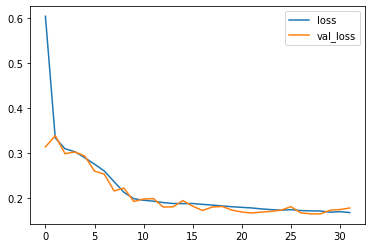

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1670 - val_loss: 0.1771
Epoch 33/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1676
Epoch 00033: val_loss improved from 0.16400 to 0.16333, saving model to model.h5
sampling a predictive mask


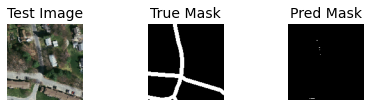

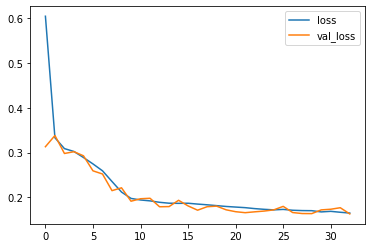

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1652 - val_loss: 0.1633
Epoch 34/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1654
Epoch 00034: val_loss improved from 0.16333 to 0.15294, saving model to model.h5
sampling a predictive mask


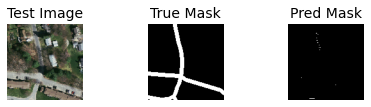

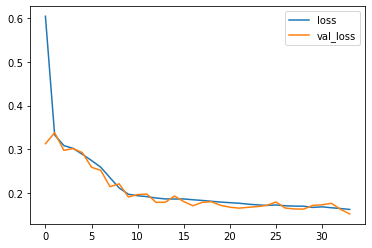

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1631 - val_loss: 0.1529
Epoch 35/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1609
Epoch 00035: val_loss did not improve from 0.15294
sampling a predictive mask


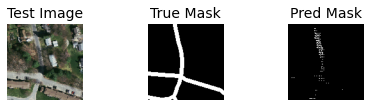

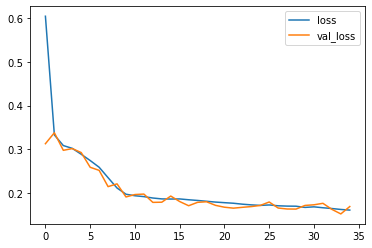

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1617 - val_loss: 0.1698
Epoch 36/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1597
Epoch 00036: val_loss did not improve from 0.15294
sampling a predictive mask


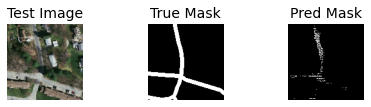

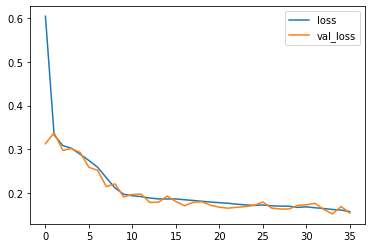

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1583 - val_loss: 0.1547
Epoch 37/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1594
Epoch 00037: val_loss did not improve from 0.15294
sampling a predictive mask


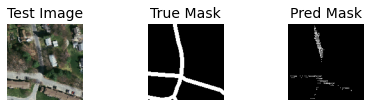

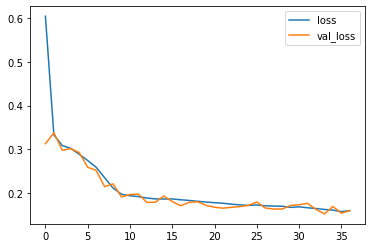

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1603 - val_loss: 0.1606
Epoch 38/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1622
Epoch 00038: val_loss improved from 0.15294 to 0.14970, saving model to model.h5
sampling a predictive mask


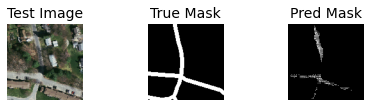

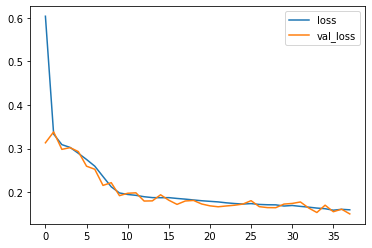

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1591 - val_loss: 0.1497
Epoch 39/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1610
Epoch 00039: val_loss improved from 0.14970 to 0.14453, saving model to model.h5
sampling a predictive mask


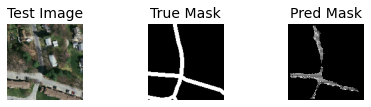

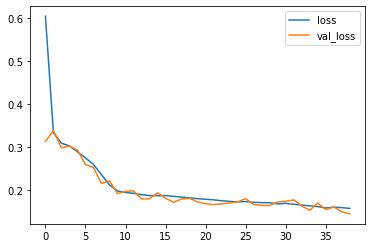

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1573 - val_loss: 0.1445
Epoch 40/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1545
Epoch 00040: val_loss improved from 0.14453 to 0.14366, saving model to model.h5
sampling a predictive mask


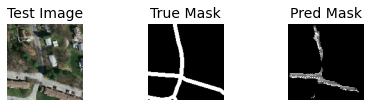

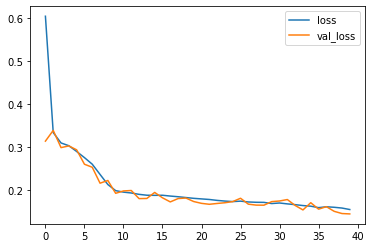

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1539 - val_loss: 0.1437
Epoch 41/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1510
Epoch 00041: val_loss improved from 0.14366 to 0.14300, saving model to model.h5
sampling a predictive mask


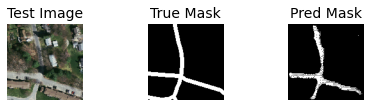

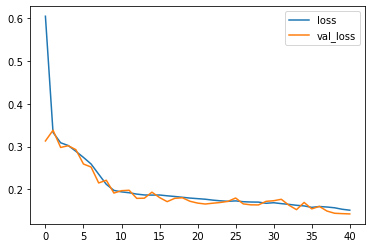

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1517 - val_loss: 0.1430
Epoch 42/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1468
Epoch 00042: val_loss did not improve from 0.14300
sampling a predictive mask


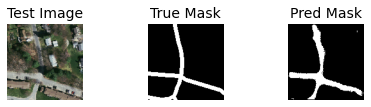

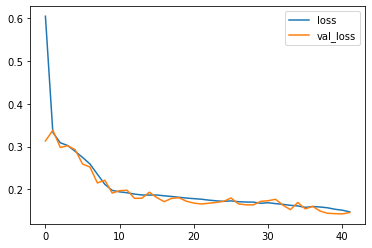

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1477 - val_loss: 0.1462
Epoch 43/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1440
Epoch 00043: val_loss did not improve from 0.14300
sampling a predictive mask


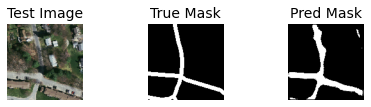

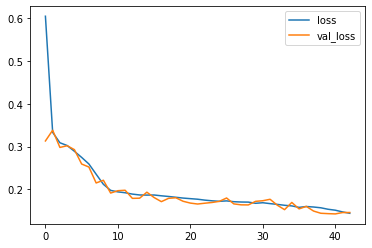

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1445 - val_loss: 0.1463
Epoch 44/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1426
Epoch 00044: val_loss improved from 0.14300 to 0.13168, saving model to model.h5
sampling a predictive mask


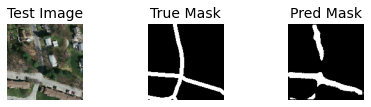

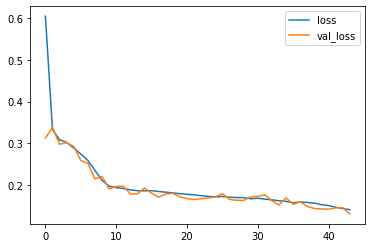

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1418 - val_loss: 0.1317
Epoch 45/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1366
Epoch 00045: val_loss did not improve from 0.13168
sampling a predictive mask


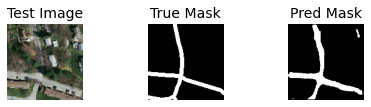

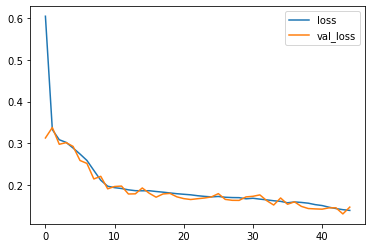

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1400 - val_loss: 0.1479
Epoch 46/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1392
Epoch 00046: val_loss did not improve from 0.13168
sampling a predictive mask


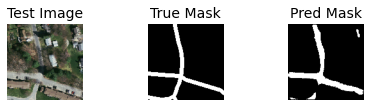

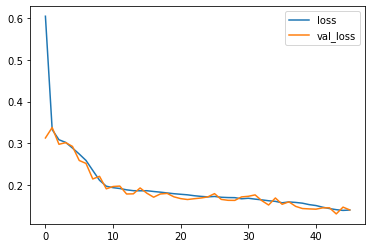

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1410 - val_loss: 0.1411
Epoch 47/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1376
Epoch 00047: val_loss improved from 0.13168 to 0.12921, saving model to model.h5
sampling a predictive mask


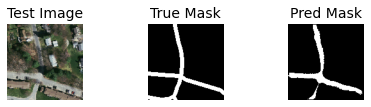

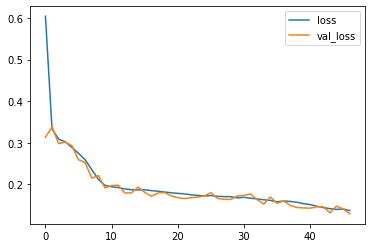

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1372 - val_loss: 0.1292
Epoch 48/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1344
Epoch 00048: val_loss improved from 0.12921 to 0.12429, saving model to model.h5
sampling a predictive mask


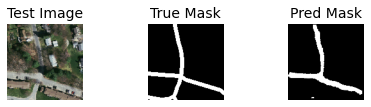

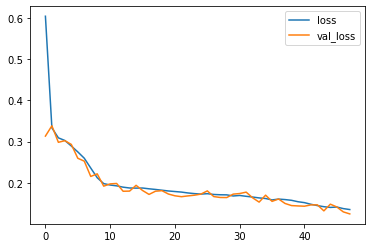

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1349 - val_loss: 0.1243
Epoch 49/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1346
Epoch 00049: val_loss did not improve from 0.12429
sampling a predictive mask


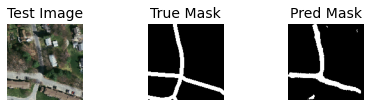

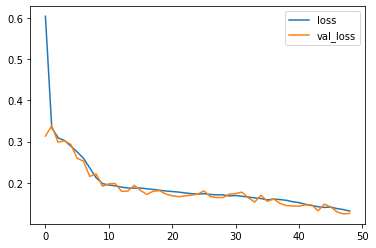

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1312 - val_loss: 0.1254
Epoch 50/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1296
Epoch 00050: val_loss did not improve from 0.12429
sampling a predictive mask


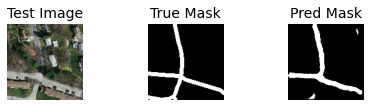

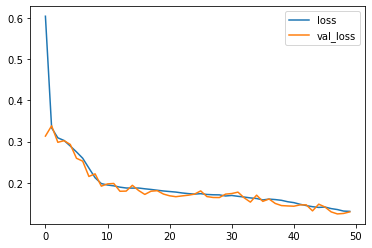

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1305 - val_loss: 0.1292
Epoch 51/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1272
Epoch 00051: val_loss improved from 0.12429 to 0.12422, saving model to model.h5
sampling a predictive mask


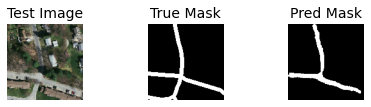

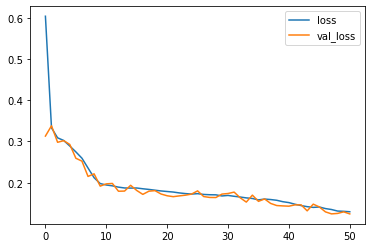

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1295 - val_loss: 0.1242
Epoch 52/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1277
Epoch 00052: val_loss improved from 0.12422 to 0.12112, saving model to model.h5
sampling a predictive mask


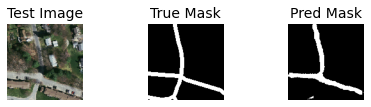

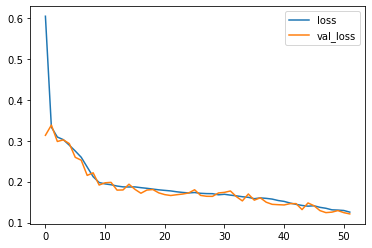

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1255 - val_loss: 0.1211
Epoch 53/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1234
Epoch 00053: val_loss improved from 0.12112 to 0.12051, saving model to model.h5
sampling a predictive mask


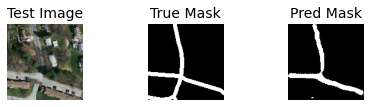

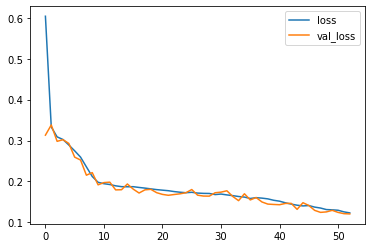

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1230 - val_loss: 0.1205
Epoch 54/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1233
Epoch 00054: val_loss did not improve from 0.12051
sampling a predictive mask


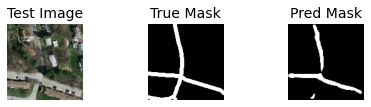

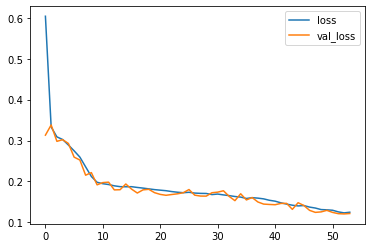

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1247 - val_loss: 0.1215
Epoch 55/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1285
Epoch 00055: val_loss did not improve from 0.12051
sampling a predictive mask


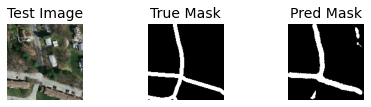

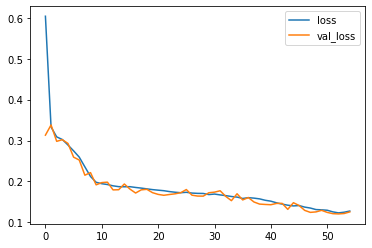

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1275 - val_loss: 0.1254
Epoch 56/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1278
Epoch 00056: val_loss improved from 0.12051 to 0.11858, saving model to model.h5
sampling a predictive mask


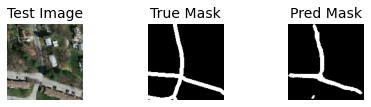

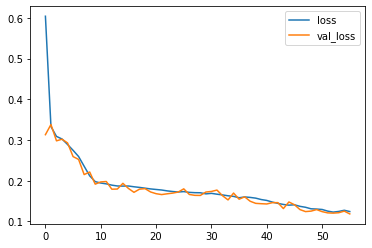

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1244 - val_loss: 0.1186
Epoch 57/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1191
Epoch 00057: val_loss improved from 0.11858 to 0.11793, saving model to model.h5
sampling a predictive mask


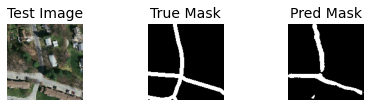

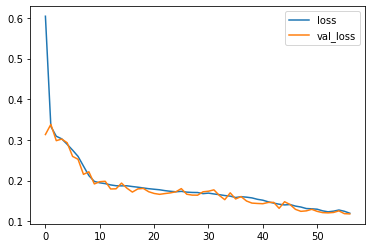

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1197 - val_loss: 0.1179
Epoch 58/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1178
Epoch 00058: val_loss improved from 0.11793 to 0.11604, saving model to model.h5
sampling a predictive mask


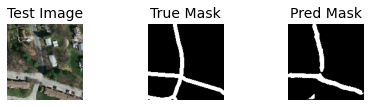

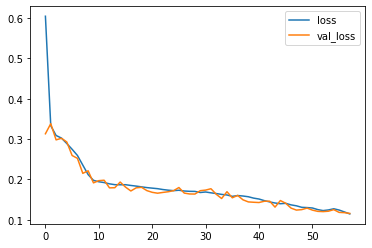

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1148 - val_loss: 0.1160
Epoch 59/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1133
Epoch 00059: val_loss did not improve from 0.11604
sampling a predictive mask


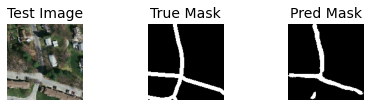

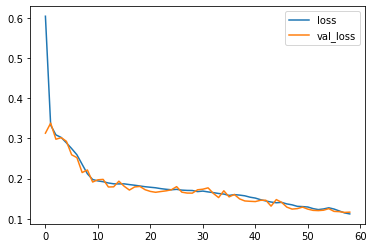

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1123 - val_loss: 0.1167
Epoch 60/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1100
Epoch 00060: val_loss improved from 0.11604 to 0.11446, saving model to model.h5
sampling a predictive mask


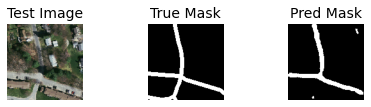

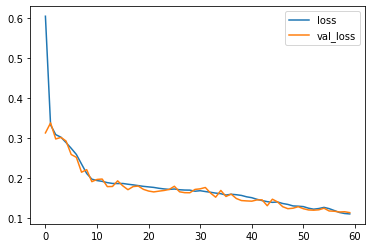

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1112 - val_loss: 0.1145
Epoch 61/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1094
Epoch 00061: val_loss did not improve from 0.11446
sampling a predictive mask


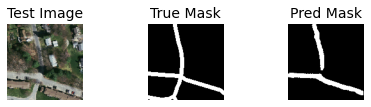

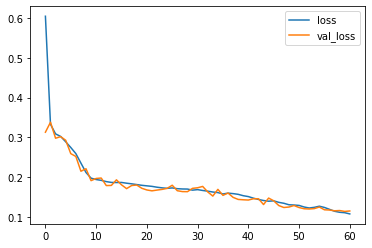

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1082 - val_loss: 0.1155
Epoch 62/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1046
Epoch 00062: val_loss improved from 0.11446 to 0.11313, saving model to model.h5
sampling a predictive mask


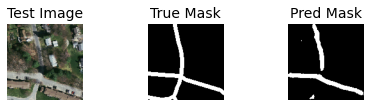

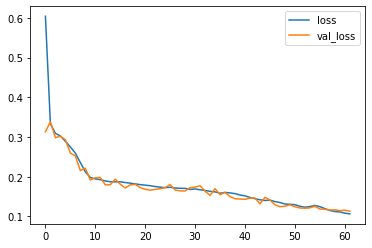

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.1062 - val_loss: 0.1131
Epoch 63/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.1055
Epoch 00063: val_loss did not improve from 0.11313
sampling a predictive mask


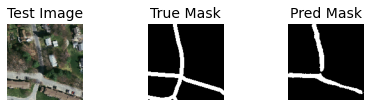

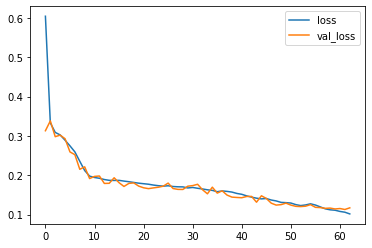

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.1019 - val_loss: 0.1173
Epoch 64/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0982
Epoch 00064: val_loss improved from 0.11313 to 0.11298, saving model to model.h5
sampling a predictive mask


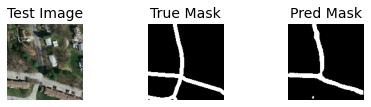

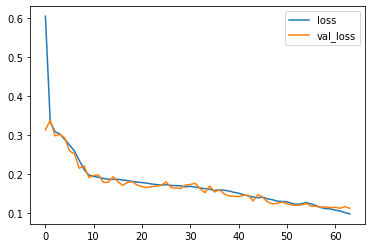

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.0986 - val_loss: 0.1130
Epoch 65/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0944
Epoch 00065: val_loss did not improve from 0.11298
sampling a predictive mask


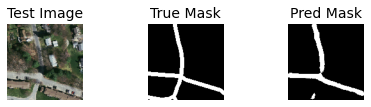

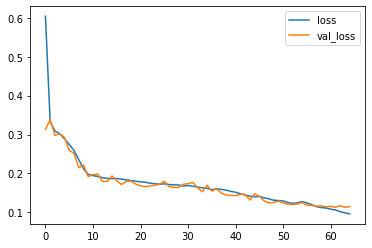

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.0961 - val_loss: 0.1151
Epoch 66/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0972
Epoch 00066: val_loss did not improve from 0.11298
sampling a predictive mask


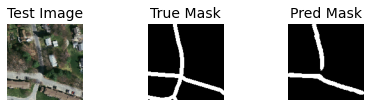

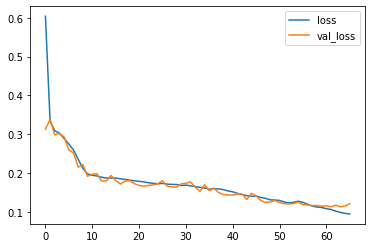

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0947 - val_loss: 0.1209
Epoch 67/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0961
Epoch 00067: val_loss did not improve from 0.11298
sampling a predictive mask


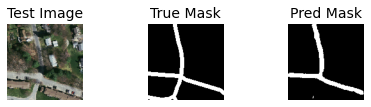

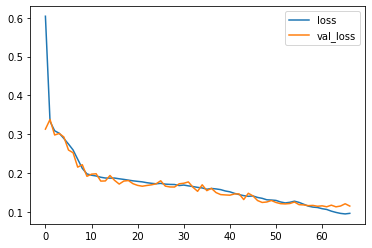

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0962 - val_loss: 0.1149
Epoch 68/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0905
Epoch 00068: val_loss did not improve from 0.11298
sampling a predictive mask


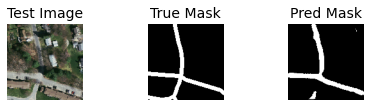

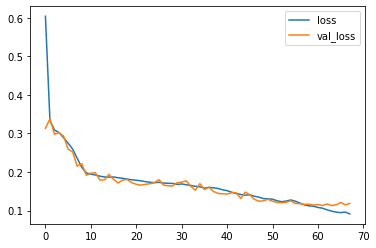

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0914 - val_loss: 0.1187
Epoch 69/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0888
Epoch 00069: val_loss did not improve from 0.11298
sampling a predictive mask


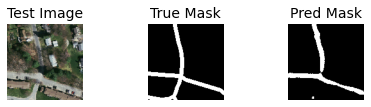

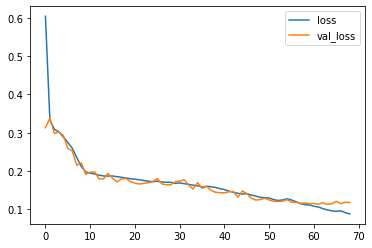

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0881 - val_loss: 0.1179
Epoch 70/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0839
Epoch 00070: val_loss did not improve from 0.11298
sampling a predictive mask


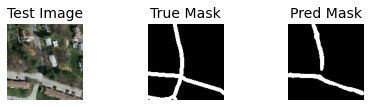

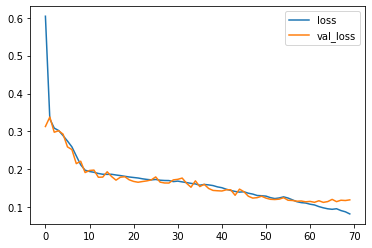

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0826 - val_loss: 0.1196
Epoch 71/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0809
Epoch 00071: val_loss did not improve from 0.11298
sampling a predictive mask


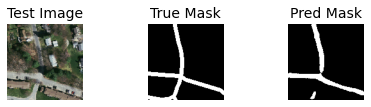

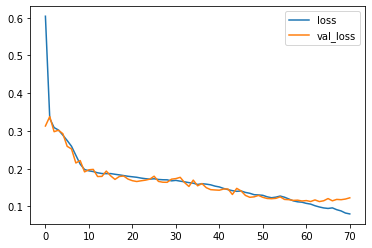

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0802 - val_loss: 0.1229
Epoch 72/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0775
Epoch 00072: val_loss did not improve from 0.11298
sampling a predictive mask


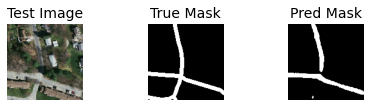

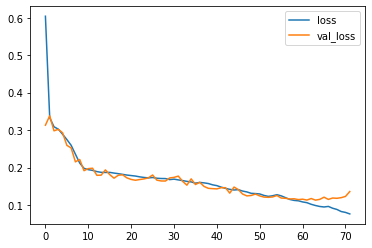

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0762 - val_loss: 0.1360
Epoch 73/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0741
Epoch 00073: val_loss did not improve from 0.11298
sampling a predictive mask


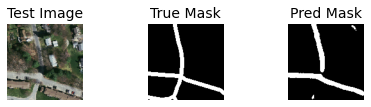

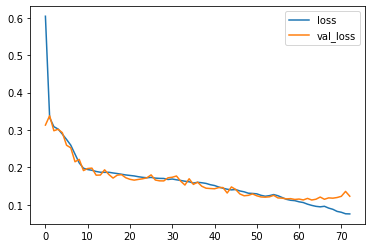

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0758 - val_loss: 0.1231
Epoch 74/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0728
Epoch 00074: val_loss did not improve from 0.11298
sampling a predictive mask


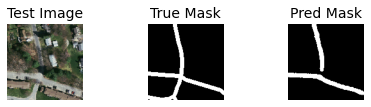

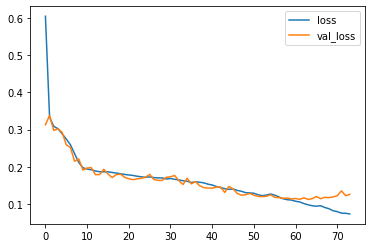

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0742 - val_loss: 0.1265
Epoch 75/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0710
Epoch 00075: val_loss did not improve from 0.11298
sampling a predictive mask


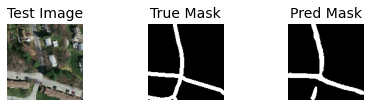

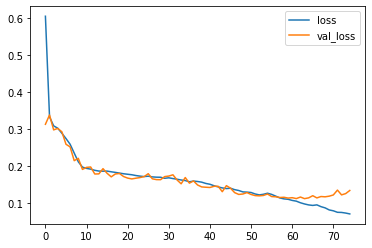

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0718 - val_loss: 0.1349
Epoch 76/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0685
Epoch 00076: val_loss did not improve from 0.11298
sampling a predictive mask


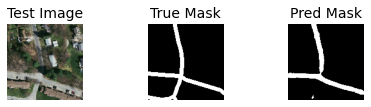

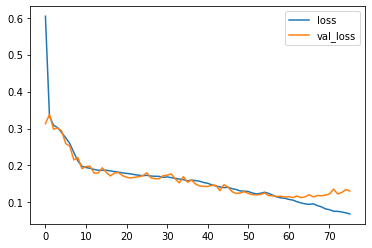

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0689 - val_loss: 0.1308
Epoch 77/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0644
Epoch 00077: val_loss did not improve from 0.11298
sampling a predictive mask


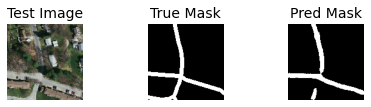

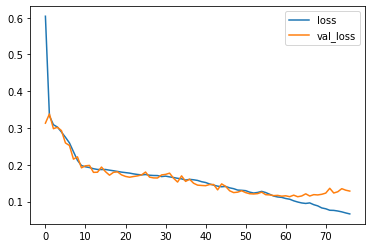

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0663 - val_loss: 0.1284
Epoch 78/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0663
Epoch 00078: val_loss did not improve from 0.11298
sampling a predictive mask


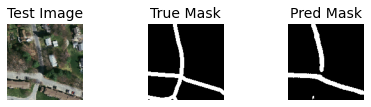

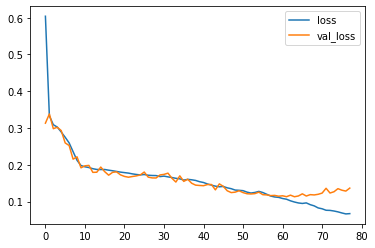

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0671 - val_loss: 0.1365
Epoch 79/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0654
Epoch 00079: val_loss did not improve from 0.11298
sampling a predictive mask


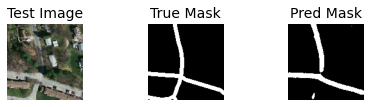

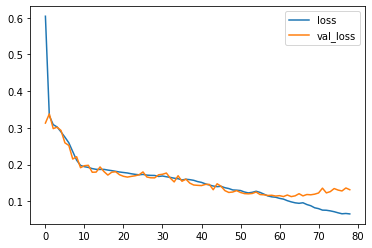

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0659 - val_loss: 0.1317
Epoch 80/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0639
Epoch 00080: val_loss did not improve from 0.11298
sampling a predictive mask


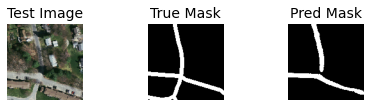

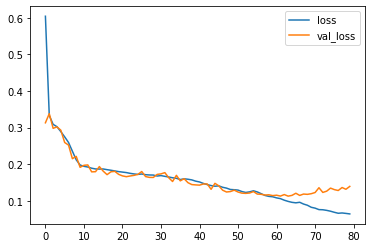

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0645 - val_loss: 0.1396
Epoch 81/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0602
Epoch 00081: val_loss did not improve from 0.11298
sampling a predictive mask


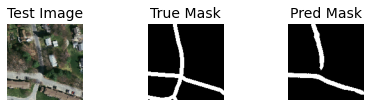

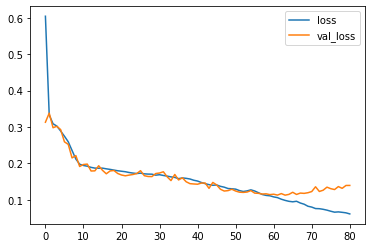

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0615 - val_loss: 0.1397
Epoch 82/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0589
Epoch 00082: val_loss did not improve from 0.11298
sampling a predictive mask


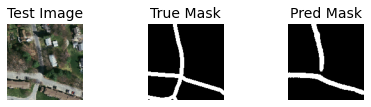

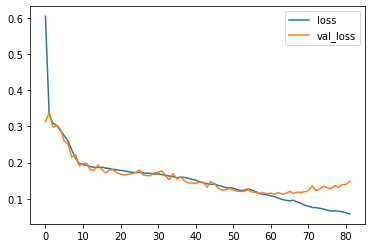

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0585 - val_loss: 0.1491
Epoch 83/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0552
Epoch 00083: val_loss did not improve from 0.11298
sampling a predictive mask


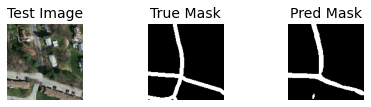

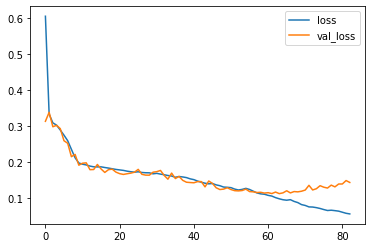

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0568 - val_loss: 0.1439
Epoch 84/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0563
Epoch 00084: val_loss did not improve from 0.11298
sampling a predictive mask


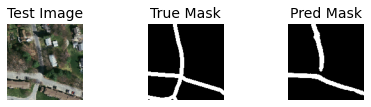

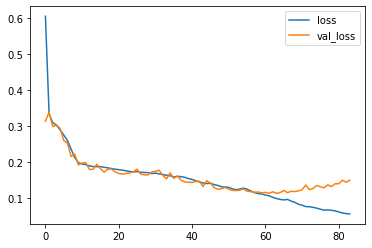

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0559 - val_loss: 0.1492
Epoch 85/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0565
Epoch 00085: val_loss did not improve from 0.11298
sampling a predictive mask


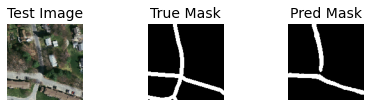

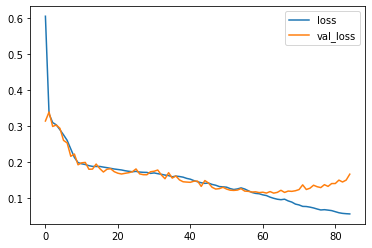

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0553 - val_loss: 0.1656
Epoch 86/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0537
Epoch 00086: val_loss did not improve from 0.11298
sampling a predictive mask


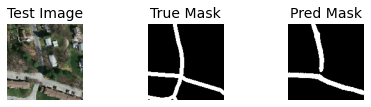

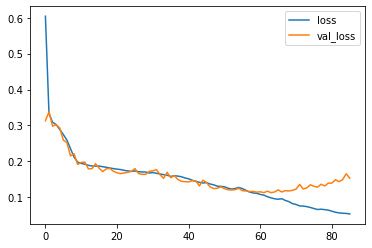

1350/1350 [==============================] - 3s 2ms/sample - loss: 0.0539 - val_loss: 0.1533
Epoch 87/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0512
Epoch 00087: val_loss did not improve from 0.11298
sampling a predictive mask


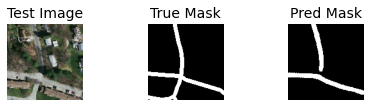

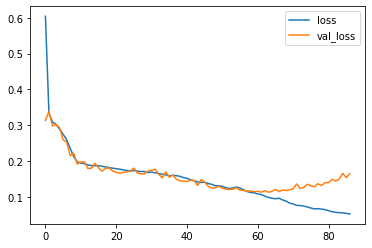

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0524 - val_loss: 0.1646
Epoch 88/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0504
Epoch 00088: val_loss did not improve from 0.11298
sampling a predictive mask


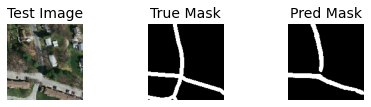

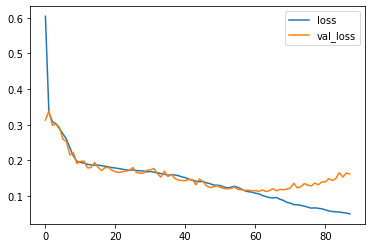

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0501 - val_loss: 0.1618
Epoch 89/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0484
Epoch 00089: val_loss did not improve from 0.11298
sampling a predictive mask


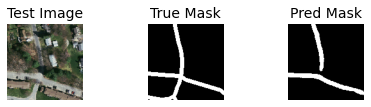

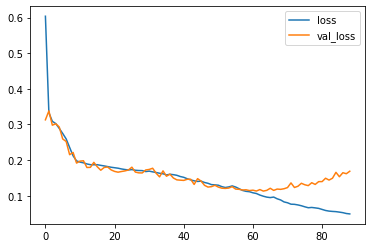

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0489 - val_loss: 0.1688
Epoch 90/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0483
Epoch 00090: val_loss did not improve from 0.11298
sampling a predictive mask


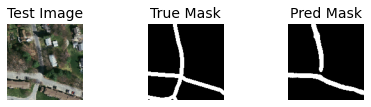

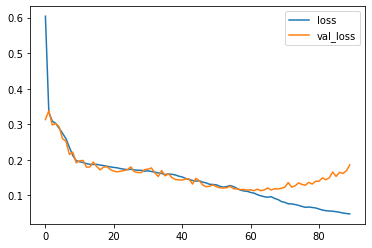

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0477 - val_loss: 0.1858
Epoch 91/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0470
Epoch 00091: val_loss did not improve from 0.11298
sampling a predictive mask


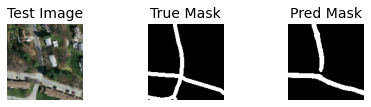

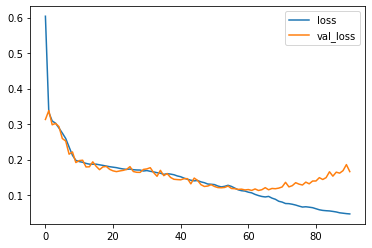

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0469 - val_loss: 0.1661
Epoch 92/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0464
Epoch 00092: val_loss did not improve from 0.11298
sampling a predictive mask


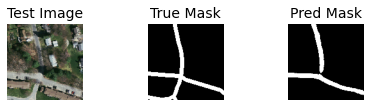

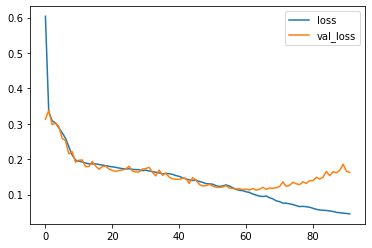

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0456 - val_loss: 0.1629
Epoch 93/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0465
Epoch 00093: val_loss did not improve from 0.11298
sampling a predictive mask


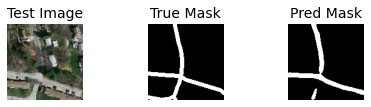

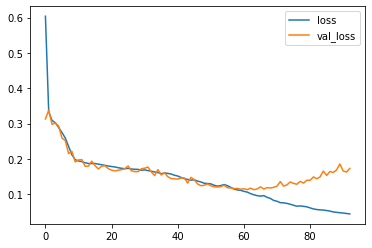

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0444 - val_loss: 0.1732
Epoch 94/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0450
Epoch 00094: val_loss did not improve from 0.11298
sampling a predictive mask


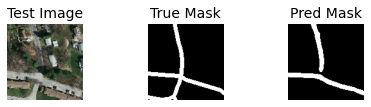

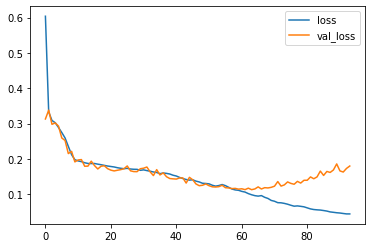

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0444 - val_loss: 0.1800
Epoch 95/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0435
Epoch 00095: val_loss did not improve from 0.11298
sampling a predictive mask


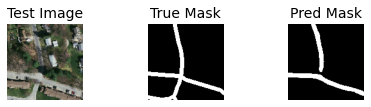

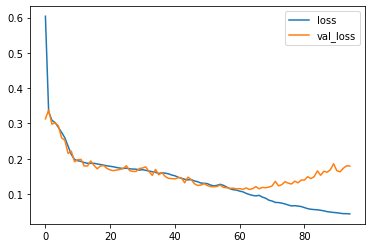

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0436 - val_loss: 0.1792
Epoch 96/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0417
Epoch 00096: val_loss did not improve from 0.11298
sampling a predictive mask


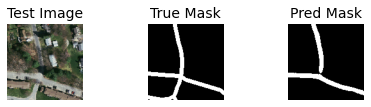

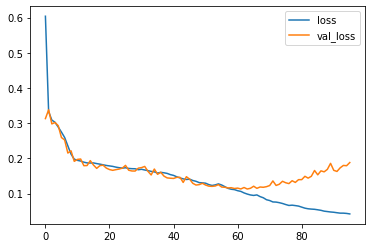

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0422 - val_loss: 0.1882
Epoch 97/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0404
Epoch 00097: val_loss did not improve from 0.11298
sampling a predictive mask


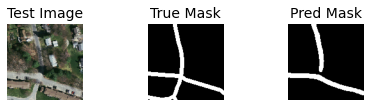

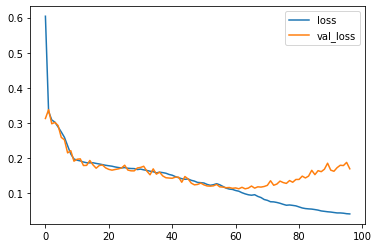

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0416 - val_loss: 0.1700
Epoch 98/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0409
Epoch 00098: val_loss did not improve from 0.11298
sampling a predictive mask


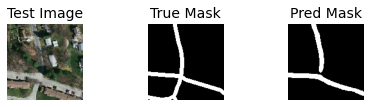

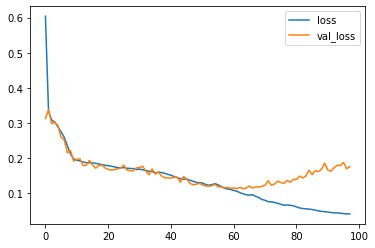

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0415 - val_loss: 0.1762
Epoch 99/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0410
Epoch 00099: val_loss did not improve from 0.11298
sampling a predictive mask


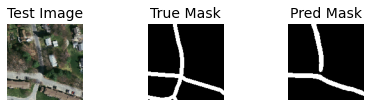

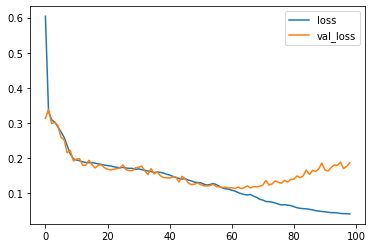

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0408 - val_loss: 0.1866
Epoch 100/100
1100/1350 [=======================>......] - ETA: 0s - loss: 0.0382
Epoch 00100: val_loss did not improve from 0.11298
sampling a predictive mask


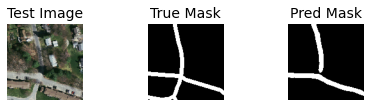

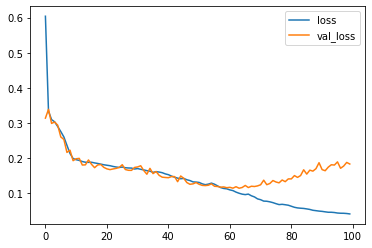

1350/1350 [==============================] - 2s 2ms/sample - loss: 0.0396 - val_loss: 0.1821
Epoch 00100: early stopping


In [59]:
filepath = "model.h5"

earlystopper = tf.keras.callbacks.EarlyStopping(patience=2, verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')



imagesampler10 = SamplePredictionsCallback(image_index = 10, prediction_thresh = 0.1)
#imagesampler20 = SamplePredictionsCallback(image_index = 3, prediction_thresh = 0.2)
#imagesampler30 = SamplePredictionsCallback(image_index = 3, prediction_thresh = 0.3)
#imagesampler40 = SamplePredictionsCallback(image_index = 3, prediction_thresh = 0.4)
imagesampler50 = SamplePredictionsCallback(image_index = 10, prediction_thresh = 0.5)
#imagesampler60 = SamplePredictionsCallback(image_index = 3, prediction_thresh = 0.6)
imagesampler70 = SamplePredictionsCallback(image_index = 10, prediction_thresh = 0.7)
imagesampler80 = SamplePredictionsCallback(image_index = 10, prediction_thresh = 0.8)
imagesampler90 = SamplePredictionsCallback(image_index = 10, prediction_thresh = 0.9)
#imagesampler100 = SamplePredictionsCallback(image_index = 3, prediction_thresh = 1.0)

callbacks_list = [earlystopper, checkpoint, imagesampler50]

history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=275, epochs=100, 
                    callbacks=callbacks_list)

In [60]:
model.load_weights('model.h5')

test_preds = model.predict(X_test)

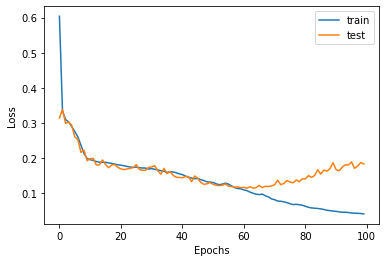

In [61]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [62]:
def plot_results(img_idx2, prediction_threshold = 0.5):
    
    preds_test_thresh = (test_preds >= prediction_threshold).astype(np.uint8)
    
    plt.figure(figsize=(10,10))
    plt.axis('Off')
    
    # image
    plt.subplot(3,3,1)
    test_image = X_test[img_idx2]
    plt.imshow(test_image)
    plt.title('Test Image {}'.format(img_idx2), fontsize=14)
    plt.axis('off')
    
    # true mask
    plt.subplot(3,3,2)
    mask_id = df_test.loc[img_idx2,'mask_id']
    path_mask = 'Roads DataSet/road_segmentation_ideal/training/output/' + mask_id
    mask = imread(path_mask)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    plt.imshow(mask, cmap='gray')
    plt.title('True Mask {}'.format(img_idx2), fontsize=14)
    plt.axis('off')

        
    # predicted mask
    plt.subplot(3,3,3)
    test_mask = preds_test_thresh[img_idx2, :, :, 0]
    plt.imshow(test_mask, cmap='gray')
    plt.title('Pred Mask {}'.format(img_idx2), fontsize=14)
    plt.axis('off')
    
    
    
    
    plt.tight_layout()
    plt.show()
    
    

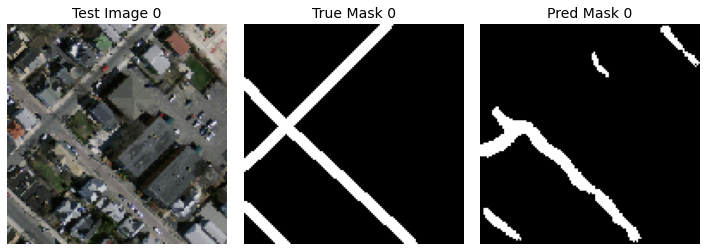

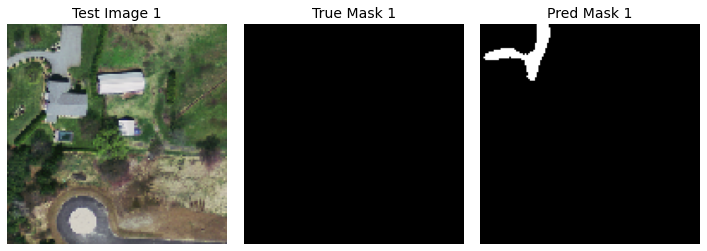

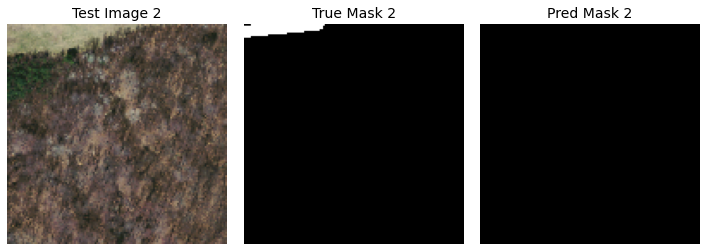

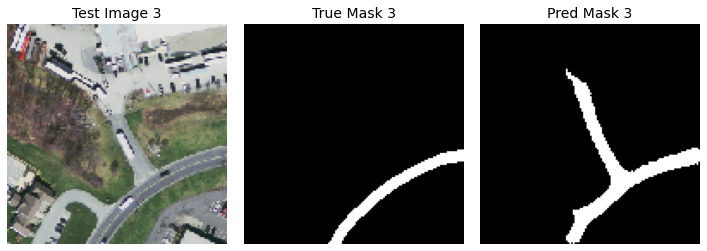

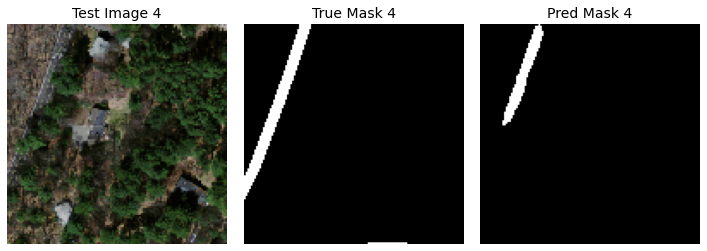

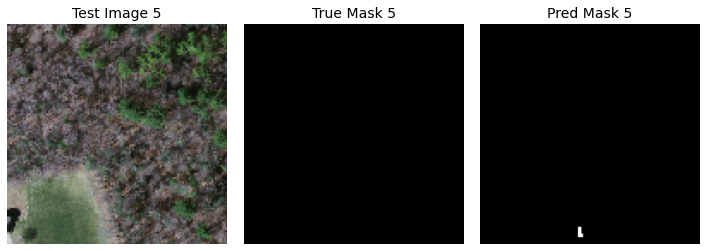

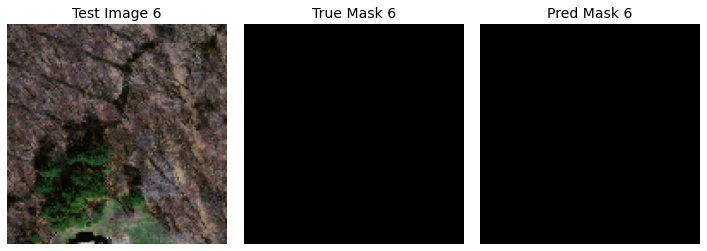

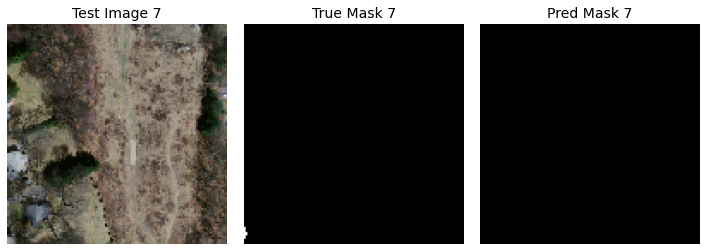

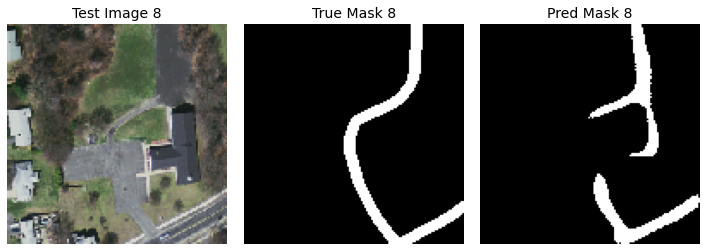

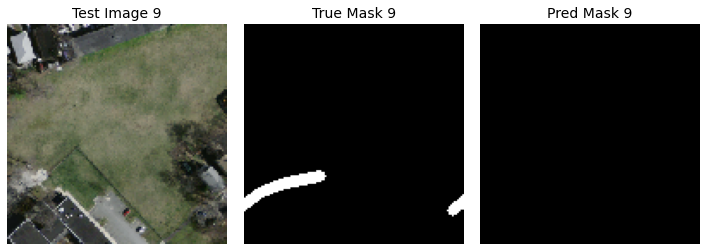

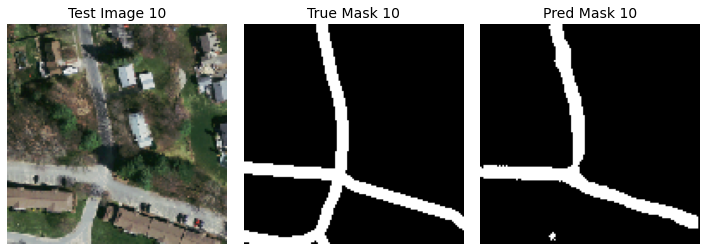

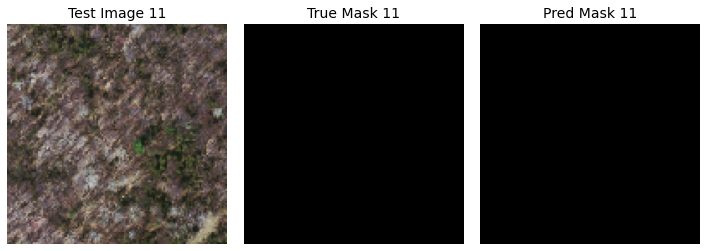

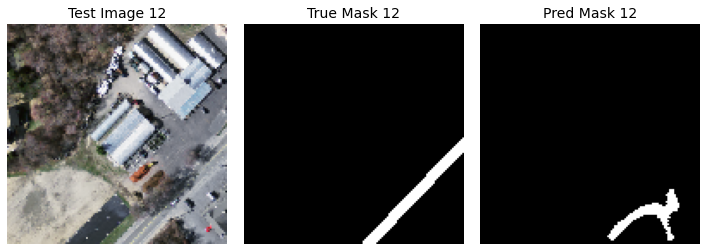

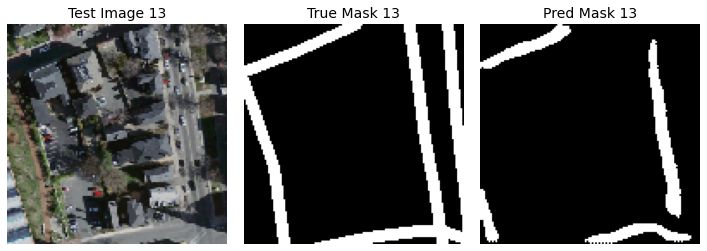

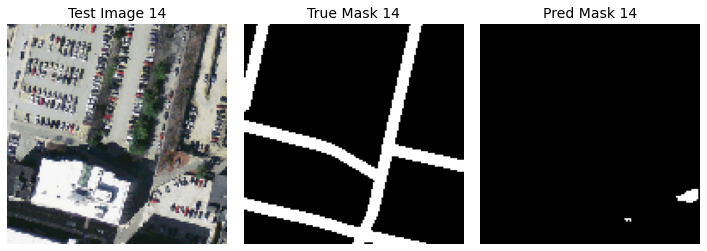

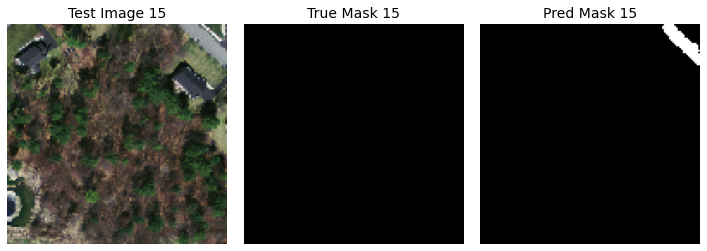

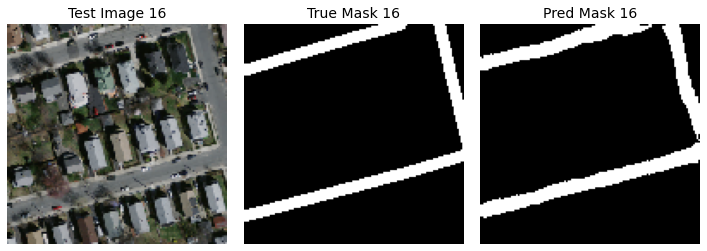

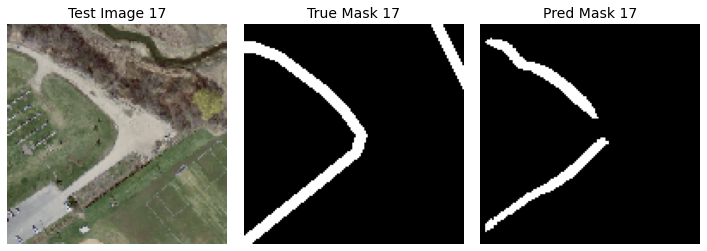

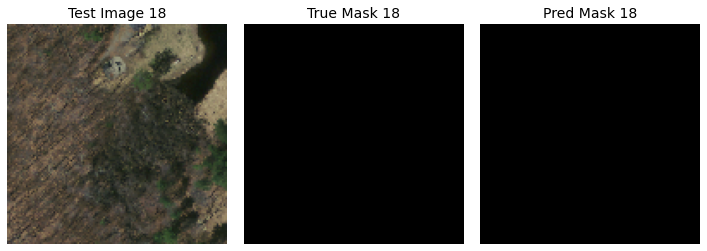

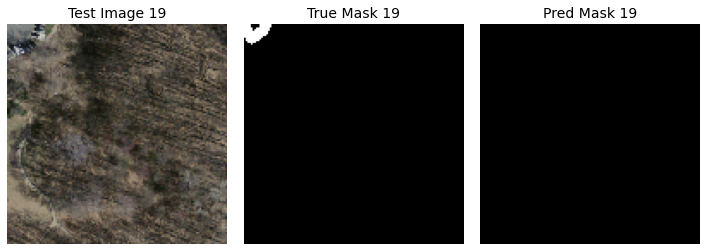

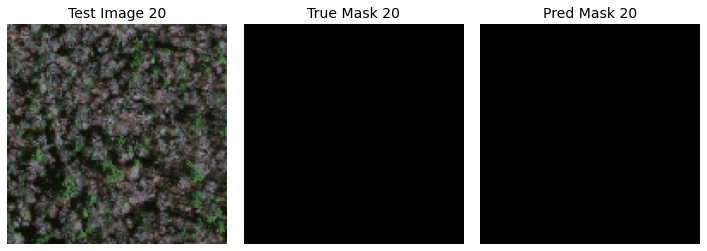

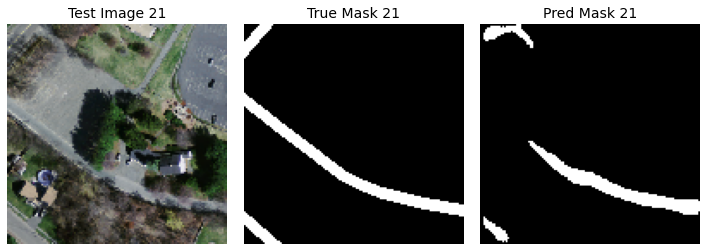

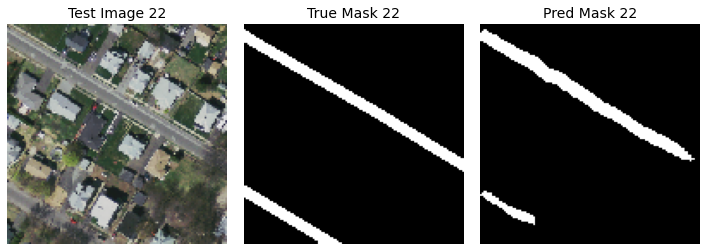

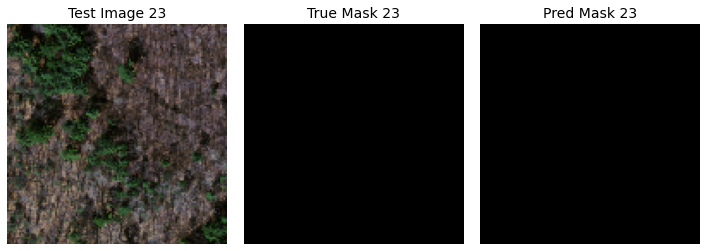

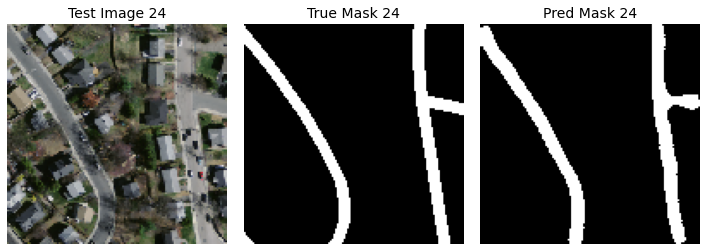

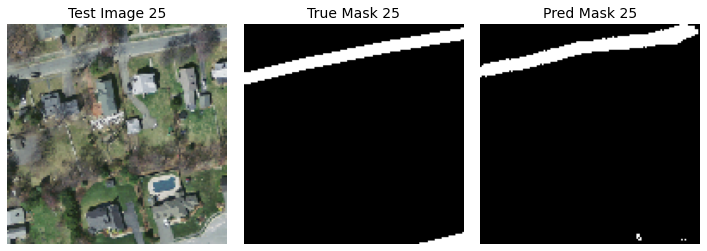

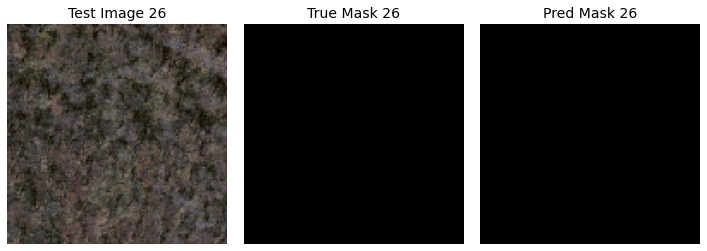

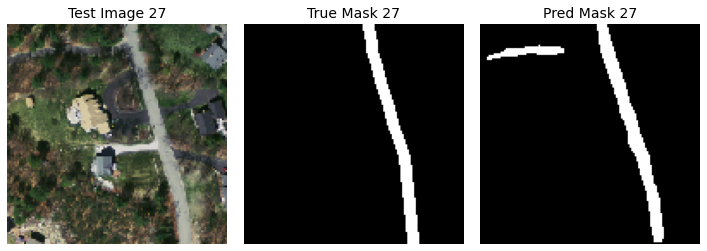

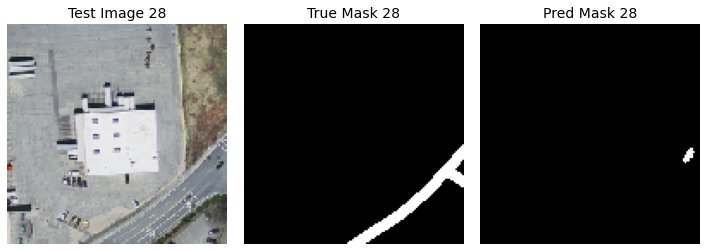

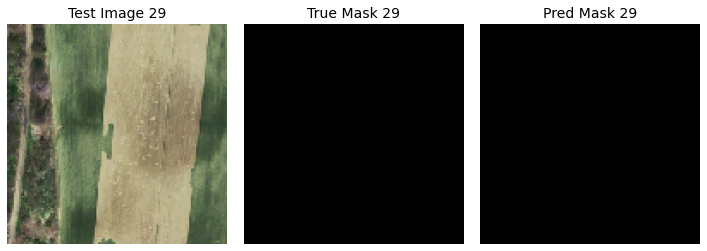

In [63]:
for i in range(len(X_test)):
    plot_results(i, prediction_threshold = 0.5)